In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:


model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=1024,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=4,
    n_stacks=2,
    dropout=0.3
)

print(model)

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=1024, bias=True)
  (embedding_output): Linear(in_features=1024, out_features=1, bias=True)
  (cont_input): Linear(in_features=4, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1028, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (stacks): ModuleList(
    (0): NeuralStack(
      (stacks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=1028, out_features=1028, bias=True)
          (layer2): Linear(in_features=1028, out_features=1028, bias=True)
          (layer3): Linear(in_features=1028, out_features=1028, bias=True)
          (layer4): Linear(in_features=1028, out_features=1028, bias=True)
          (output): Linear(in_features=1028, out_features=1028, bias=True)
          (res_layer): Linear(in_features=1028, out_features=1028, bias=True)
     

# Loop throug each stock
Create Trainer only once

Using cuda-device
Start training for stock: 1301


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: <<< 0 >>>

                    Average train loss: 0.006370836496353149 | 
                    Train-Mae: 0.12178513407707214 |

                    Average val loss: 0.010125438682734966|
                    Val-Mae: 0.07930848747491837
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0027275610715150832 | 
                    Train-Mae: 0.12402414530515671 |

                    Average val loss: 0.009011201560497284|
                    Val-Mae: 0.07394570112228394
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0018999900668859482 | 
                    Train-Mae: 0.1185021847486496 |

                    Average val loss: 0.008484368212521076|
                    Val-Mae: 0.07095718383789062
                    
.................... End of epoch 4 ....................


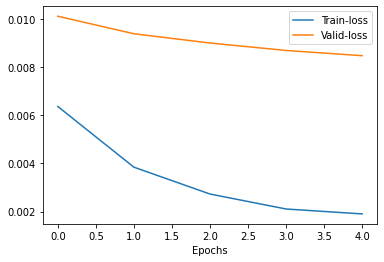

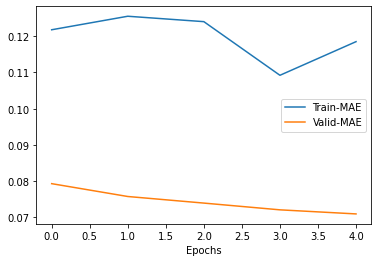

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0016361899673938752 | 
                    Train-Mae: 0.1544075757265091 |

                    Average val loss: 0.008415798656642437|
                    Val-Mae: 0.07008010894060135
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0013921378180384637 | 
                    Train-Mae: 0.14470955729484558 |

                    Average val loss: 0.008617612533271313|
                    Val-Mae: 0.07122902572154999
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0014437197707593441 | 
                    Train-Mae: 0.13452844321727753 |

                    Average val loss: 0.007878298871219158|
                    Val-Mae: 0.0675419494509697
                    
.................... End of epoch 4 ....................


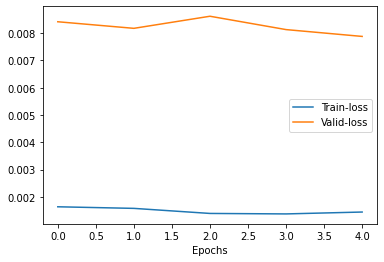

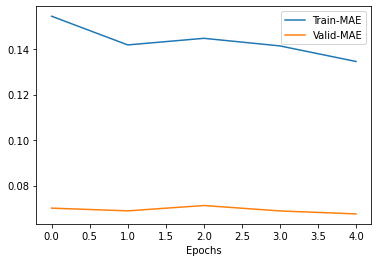

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0014240714721381665 | 
                    Train-Mae: 0.13276831805706024 |

                    Average val loss: 0.007587919477373362|
                    Val-Mae: 0.06729865074157715
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.001259967591613531 | 
                    Train-Mae: 0.1174282357096672 |

                    Average val loss: 0.007628642953932285|
                    Val-Mae: 0.067953921854496
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0013276251032948495 | 
                    Train-Mae: 0.11174842715263367 |

                    Average val loss: 0.0068913898430764675|
                    Val-Mae: 0.0627998635172844
                    
.................... End of epoch 4 ....................


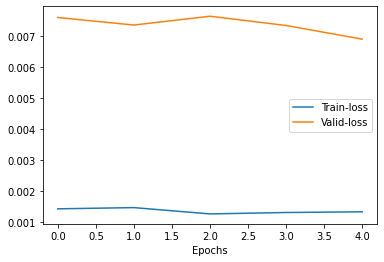

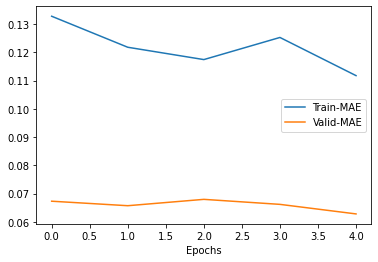

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0014791041612625122 | 
                    Train-Mae: 0.11546129733324051 |

                    Average val loss: 0.008170959539711475|
                    Val-Mae: 0.06938480585813522
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0015623288229107857 | 
                    Train-Mae: 0.11964147537946701 |

                    Average val loss: 0.008017194457352161|
                    Val-Mae: 0.06872895359992981
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0015405083075165748 | 
                    Train-Mae: 0.10772638022899628 |

                    Average val loss: 0.007800982799381018|
                    Val-Mae: 0.0676073431968689
                    
.................... End of epoch 4 ....................


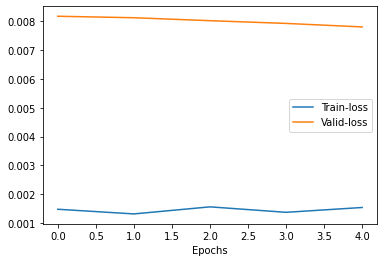

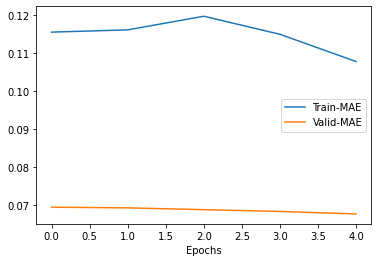

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0016714278608560562 | 
                    Train-Mae: 0.11171979457139969 |

                    Average val loss: 0.007544113788753748|
                    Val-Mae: 0.06680566072463989
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0016020288690924644 | 
                    Train-Mae: 0.10987335443496704 |

                    Average val loss: 0.007247542031109333|
                    Val-Mae: 0.06515908241271973
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0014037525281310082 | 
                    Train-Mae: 0.1154981479048729 |

                    Average val loss: 0.00696024764329195|
                    Val-Mae: 0.06352760642766953
                    
.................... End of epoch 4 ....................


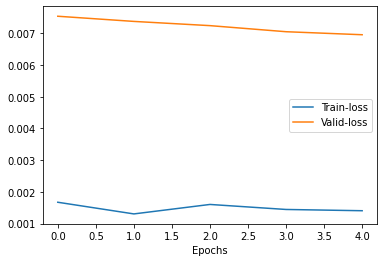

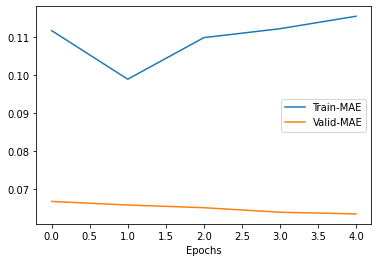

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0012145484797656536 | 
                    Train-Mae: 0.12242620438337326 |

                    Average val loss: 0.010750006884336472|
                    Val-Mae: 0.07914149016141891
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0013236938044428825 | 
                    Train-Mae: 0.10409121215343475 |

                    Average val loss: 0.010213259607553482|
                    Val-Mae: 0.07723978161811829
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0011718440800905228 | 
                    Train-Mae: 0.1066412627696991 |

                    Average val loss: 0.009941681288182735|
                    Val-Mae: 0.07620935142040253
                    
.................... End of epoch 4 ....................


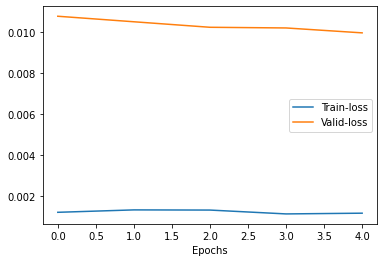

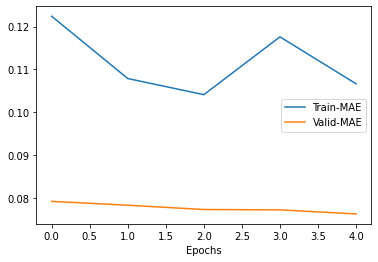

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0012595973908901214 | 
                    Train-Mae: 0.10130554437637329 |

                    Average val loss: 0.0062529598362743855|
                    Val-Mae: 0.057130470871925354
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.001266020629554987 | 
                    Train-Mae: 0.0998038575053215 |

                    Average val loss: 0.006157964002341032|
                    Val-Mae: 0.05663837492465973
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0012450478971004486 | 
                    Train-Mae: 0.09892983734607697 |

                    Average val loss: 0.006182829849421978|
                    Val-Mae: 0.05703454837203026
                    
.................... End of epoch 4 ....................


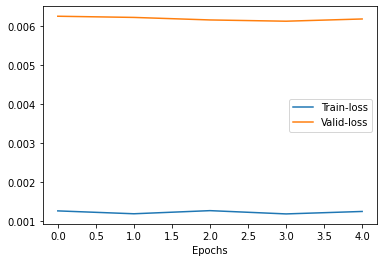

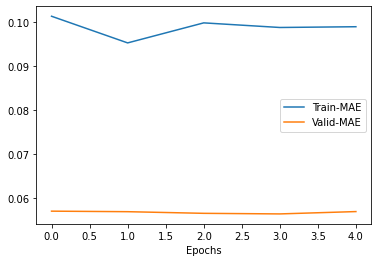

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.001074777077883482 | 
                    Train-Mae: 0.12469467520713806 |

                    Average val loss: 0.0842147246003151|
                    Val-Mae: 0.2543784976005554
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0009655073285102844 | 
                    Train-Mae: 0.12015312165021896 |

                    Average val loss: 0.06613150238990784|
                    Val-Mae: 0.22279566526412964
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0010965365916490554 | 
                    Train-Mae: 0.12638908624649048 |

                    Average val loss: 0.046140335500240326|
                    Val-Mae: 0.18265658617019653
                    
.................... End of epoch 4 ....................


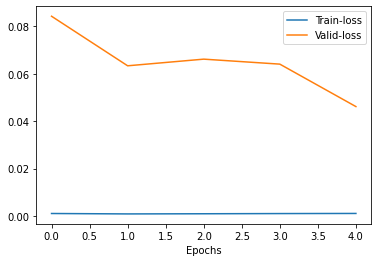

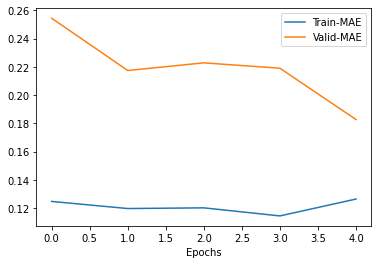

####################

Start training for stock: 1414
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0012813640758395195 | 
                    Train-Mae: 0.10940679907798767 |

                    Average val loss: 0.005059264600276947|
                    Val-Mae: 0.05375897139310837
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0010055825114250183 | 
                    Train-Mae: 0.10050241649150848 |

                    Average val loss: 0.004994362127035856|
                    Val-Mae: 0.05361821502447128
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0010198839008808136 | 
                    Train-Mae: 0.10791719704866409 |

                    Average val loss: 0.004763311706483364|
                    Val-Mae: 0.05126076564192772
                    
.................... End of epoch 4 ....................


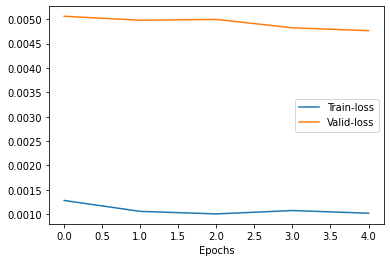

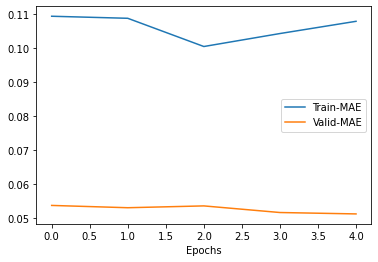

####################

Start training for stock: 1417
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0011770613491535187 | 
                    Train-Mae: 0.09861841797828674 |

                    Average val loss: 0.011081174947321415|
                    Val-Mae: 0.08336205780506134
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0009182499721646309 | 
                    Train-Mae: 0.09465666860342026 |

                    Average val loss: 0.012383476831018925|
                    Val-Mae: 0.08844044059515
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0009109539911150933 | 
                    Train-Mae: 0.09641948342323303 |

                    Average val loss: 0.012878449633717537|
                    Val-Mae: 0.09026166051626205
                    
.................... End of epoch 4 ....................


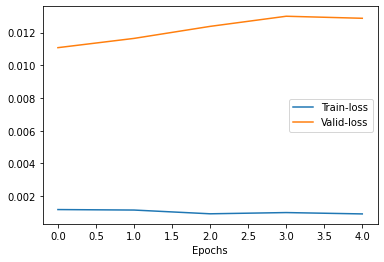

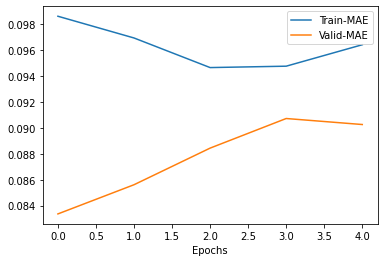

####################

Start training for stock: 1419
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0010912615805864334 | 
                    Train-Mae: 0.10875670611858368 |

                    Average val loss: 0.03289147466421127|
                    Val-Mae: 0.1515883356332779
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0010504743084311485 | 
                    Train-Mae: 0.10629834234714508 |

                    Average val loss: 0.024705884978175163|
                    Val-Mae: 0.13015364110469818
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0009902846068143845 | 
                    Train-Mae: 0.10985643416643143 |

                    Average val loss: 0.0194025170058012|
                    Val-Mae: 0.1141565591096878
                    
.................... End of epoch 4 ....................


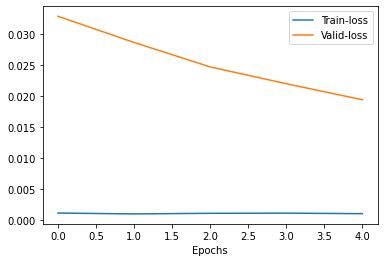

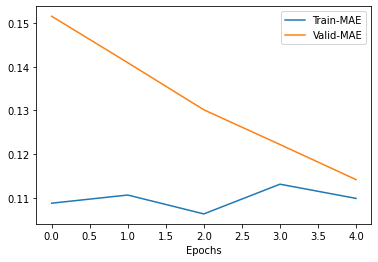

####################

Start training for stock: 1429
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0008549108169972897 | 
                    Train-Mae: 0.10582515597343445 |

                    Average val loss: 0.0055740997195243835|
                    Val-Mae: 0.0558231845498085
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.001016151625663042 | 
                    Train-Mae: 0.11258093267679214 |

                    Average val loss: 0.005417884327471256|
                    Val-Mae: 0.054920744150877
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0009048493579030037 | 
                    Train-Mae: 0.10653996467590332 |

                    Average val loss: 0.005394856445491314|
                    Val-Mae: 0.054829418659210205
                    
.................... End of epoch 4 ....................


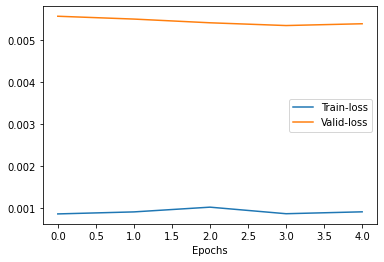

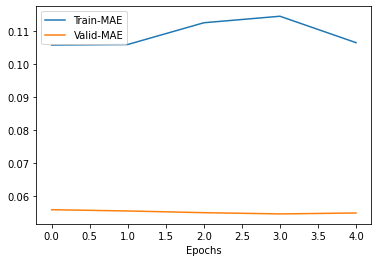

####################

Start training for stock: 1435
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0010694625787436962 | 
                    Train-Mae: 0.09272515773773193 |

                    Average val loss: 0.005137941334396601|
                    Val-Mae: 0.05227870121598244
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0009049572050571442 | 
                    Train-Mae: 0.09610617905855179 |

                    Average val loss: 0.00511256605386734|
                    Val-Mae: 0.05271436646580696
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0010495826601982117 | 
                    Train-Mae: 0.0900130644440651 |

                    Average val loss: 0.0050910902209579945|
                    Val-Mae: 0.0530281737446785
                    
.................... End of epoch 4 ....................


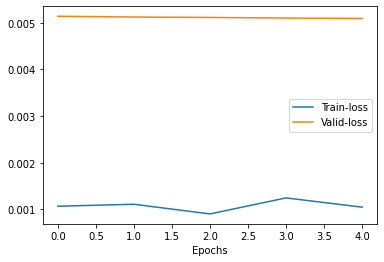

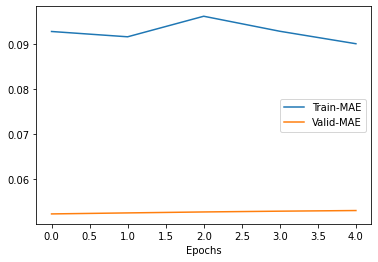

####################

Start training for stock: 1515
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0009771083481609822 | 
                    Train-Mae: 0.08681570738554001 |

                    Average val loss: 0.005056980066001415|
                    Val-Mae: 0.05300555005669594
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0010790620930492879 | 
                    Train-Mae: 0.09097372740507126 |

                    Average val loss: 0.005014393944293261|
                    Val-Mae: 0.05280643329024315
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0010412286035716533 | 
                    Train-Mae: 0.08914092183113098 |

                    Average val loss: 0.005015058442950249|
                    Val-Mae: 0.05292752385139465
                    
.................... End of epoch 4 ....................


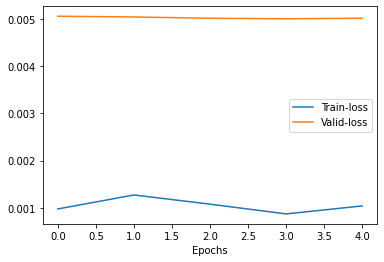

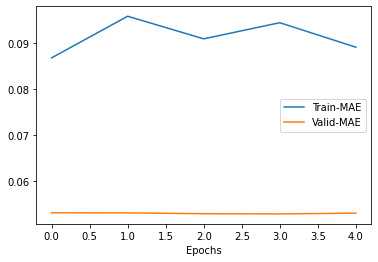

####################

Start training for stock: 1518
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0009903795085847377 | 
                    Train-Mae: 0.0998740866780281 |

                    Average val loss: 0.00573715241625905|
                    Val-Mae: 0.06133478134870529
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0007726449985057116 | 
                    Train-Mae: 0.09805188328027725 |

                    Average val loss: 0.005470752716064453|
                    Val-Mae: 0.05919687822461128
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0008355244994163513 | 
                    Train-Mae: 0.0970311090350151 |

                    Average val loss: 0.005052219610661268|
                    Val-Mae: 0.055388424545526505
                    
.................... End of epoch 4 ....................


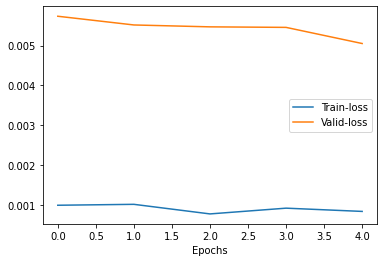

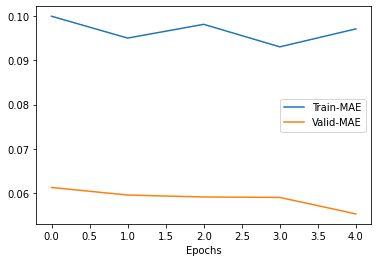

####################

Start training for stock: 1605
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0009691165760159492 | 
                    Train-Mae: 0.09113817662000656 |

                    Average val loss: 0.004486034158617258|
                    Val-Mae: 0.049977220594882965
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0007617013994604349 | 
                    Train-Mae: 0.09612876176834106 |

                    Average val loss: 0.004361748229712248|
                    Val-Mae: 0.04888363555073738
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0009456856176257133 | 
                    Train-Mae: 0.10373908281326294 |

                    Average val loss: 0.00423825066536665|
                    Val-Mae: 0.047743991017341614
                    
.................... End of epoch 4 ....................


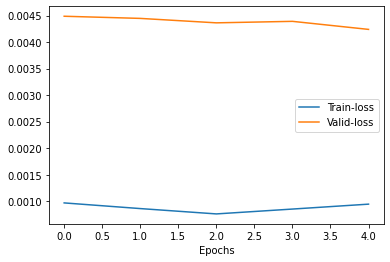

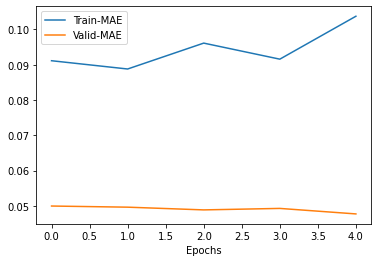

####################

Start training for stock: 1662
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0008543116971850395 | 
                    Train-Mae: 0.08889036625623703 |

                    Average val loss: 0.004684607498347759|
                    Val-Mae: 0.05008555203676224
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.000969636719673872 | 
                    Train-Mae: 0.0970274806022644 |

                    Average val loss: 0.004596900660544634|
                    Val-Mae: 0.04926742985844612
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0007381593342870474 | 
                    Train-Mae: 0.09657157957553864 |

                    Average val loss: 0.004544037859886885|
                    Val-Mae: 0.04882030934095383
                    
.................... End of epoch 4 ....................


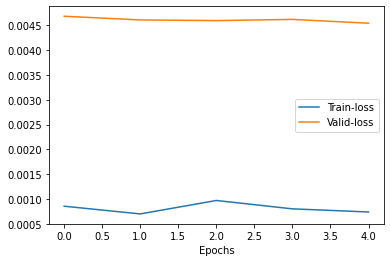

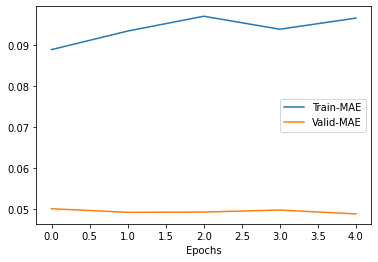

####################

Start training for stock: 1663
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0009123241528868675 | 
                    Train-Mae: 0.09974458813667297 |

                    Average val loss: 0.0048742154613137245|
                    Val-Mae: 0.05287427082657814
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0009826580062508583 | 
                    Train-Mae: 0.09749215096235275 |

                    Average val loss: 0.004987050779163837|
                    Val-Mae: 0.054421089589595795
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0008464708924293518 | 
                    Train-Mae: 0.09487689286470413 |

                    Average val loss: 0.004994838964194059|
                    Val-Mae: 0.05470190569758415
                    
.................... End of epoch 4 ....................


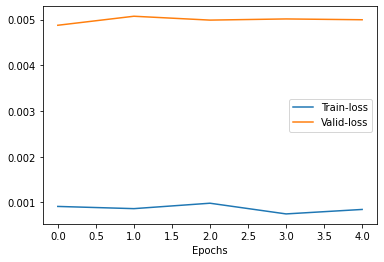

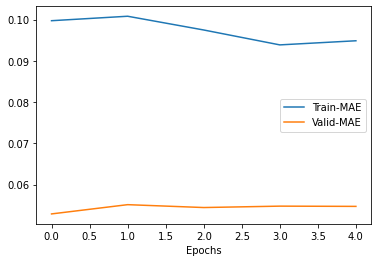

####################

Start training for stock: 1712
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0009154564701020718 | 
                    Train-Mae: 0.07745271921157837 |

                    Average val loss: 0.006224633194506168|
                    Val-Mae: 0.05859965458512306
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0009662121534347534 | 
                    Train-Mae: 0.08741744607686996 |

                    Average val loss: 0.005932776257395744|
                    Val-Mae: 0.05753851681947708
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.000852474756538868 | 
                    Train-Mae: 0.09242133796215057 |

                    Average val loss: 0.0059802476316690445|
                    Val-Mae: 0.05777399241924286
                    
.................... End of epoch 4 ....................


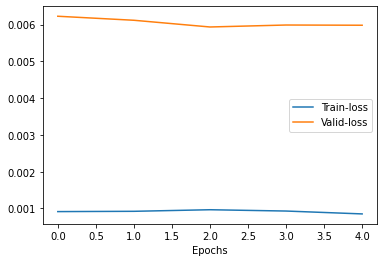

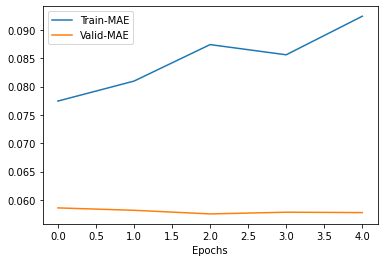

####################

Start training for stock: 1716
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0008476365357637406 | 
                    Train-Mae: 0.09197092056274414 |

                    Average val loss: 0.003830485511571169|
                    Val-Mae: 0.044707853347063065
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0008443141356110573 | 
                    Train-Mae: 0.08924791216850281 |

                    Average val loss: 0.0037964226212352514|
                    Val-Mae: 0.04352514445781708
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0009705002419650554 | 
                    Train-Mae: 0.08900823444128036 |

                    Average val loss: 0.003745931899175048|
                    Val-Mae: 0.04331570491194725
                    
.................... End of epoch 4 ....................


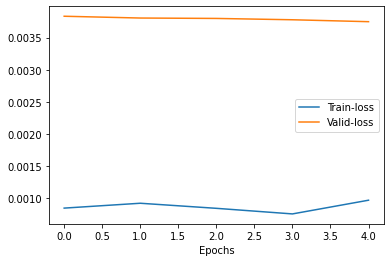

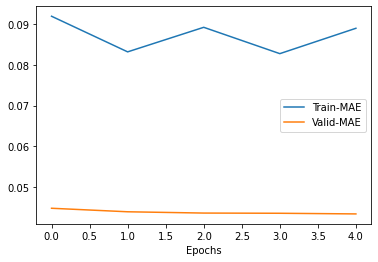

####################

Start training for stock: 1719
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0008925382979214191 | 
                    Train-Mae: 0.0816807746887207 |

                    Average val loss: 0.004633053205907345|
                    Val-Mae: 0.04809059202671051
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0008870763704180717 | 
                    Train-Mae: 0.08950994908809662 |

                    Average val loss: 0.0046052816323935986|
                    Val-Mae: 0.04791761934757233
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0008436891250312329 | 
                    Train-Mae: 0.09195687621831894 |

                    Average val loss: 0.004579642321914434|
                    Val-Mae: 0.047790974378585815
                    
.................... End of epoch 4 ....................


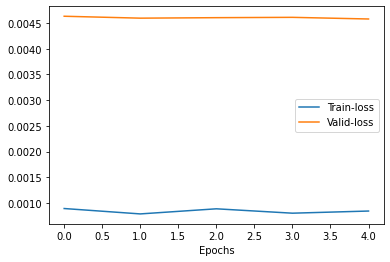

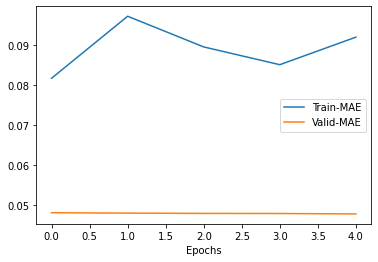

####################

Start training for stock: 1720
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0007612044923007488 | 
                    Train-Mae: 0.078153096139431 |

                    Average val loss: 0.00382646219804883|
                    Val-Mae: 0.04540686309337616
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0007054857909679413 | 
                    Train-Mae: 0.08314964175224304 |

                    Average val loss: 0.003703111782670021|
                    Val-Mae: 0.0441293828189373
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0006576540414243937 | 
                    Train-Mae: 0.0879436656832695 |

                    Average val loss: 0.003543979488313198|
                    Val-Mae: 0.04223538190126419
                    
.................... End of epoch 4 ....................


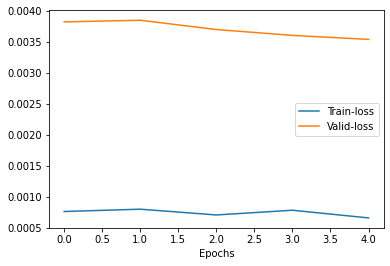

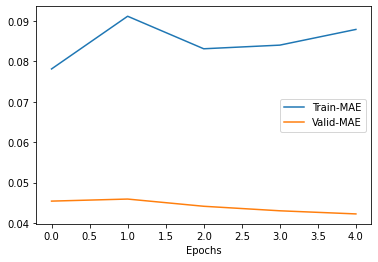

####################

Start training for stock: 1721
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0007838699966669083 | 
                    Train-Mae: 0.08547522872686386 |

                    Average val loss: 0.0036863614805042744|
                    Val-Mae: 0.045250557363033295
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0007818603888154029 | 
                    Train-Mae: 0.08495205640792847 |

                    Average val loss: 0.003793288255110383|
                    Val-Mae: 0.04656732454895973
                    
.................... End of epoch 2 ....................
Epoch: <<< 4 >>>

                    Average train loss: 0.0007353839930146933 | 
                    Train-Mae: 0.09070975333452225 |

                    Average val loss: 0.0036466075107455254|
                    Val-Mae: 0.04527829587459564
                    
.................... End of epoch 4 ....................


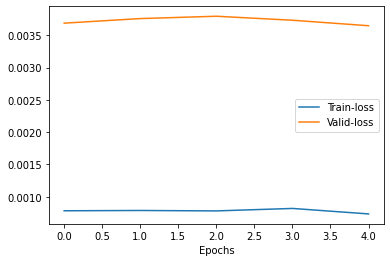

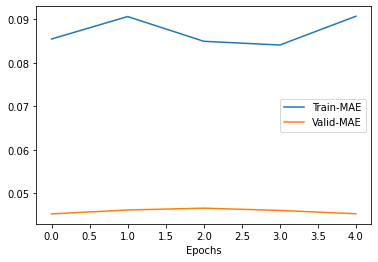

####################

Start training for stock: 1723
continuos shape: (1202, 9)  categorical shape: (1202, 4)


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch: <<< 0 >>>

                    Average train loss: 0.0006831858307123184 | 
                    Train-Mae: 0.09644025564193726 |

                    Average val loss: 0.0070500606670975685|
                    Val-Mae: 0.07194707542657852
                    
.................... End of epoch 0 ....................
Epoch: <<< 2 >>>

                    Average train loss: 0.0006458164192736149 | 
                    Train-Mae: 0.09954807162284851 |

                    Average val loss: 0.0056261238642036915|
                    Val-Mae: 0.06316876411437988
                    
.................... End of epoch 2 ....................


In [ ]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512

trainer = Trainer(model, optimizer_name='rmsprop', lr=1.3333e-6)
torch.autograd.set_detect_anomaly(True)

for s in stocks:
    train_loader, val_dataloader = None, None
    if count > 60:
        break
    print(f'Start training for stock: {s}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, s, batch_size=BATCH_SIZE, continous_cols=CONT_COLS)

    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=5
    )
    print('#' * 20)
    print()
    count += 1
    
trainer.save_model(model)

    